## Final model (V3, but cleaned up and commented)

#### Data Preparation

In [2]:
# Image Preparation Imports
import cv2
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
from glob import glob
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam

file_name = '../data/wiki.mat'

def matlab_datenum_to_date(matlab_dn):
    return datetime.date.fromordinal(int(matlab_dn) - 366)

def compute_wiki_age(photo_year, birth_datenum):
    photo_date = datetime.date(photo_year, 7, 1)
    birth_date = matlab_datenum_to_date(birth_datenum)
    delta = photo_date - birth_date
    return delta.days / 365.2425


def process_matfile(file_name):
    # Load the data
    data = loadmat(file_name)['wiki'][0, 0]
    data_dict = {key: data[key] for key in data.dtype.names}

    # Convert data into filename-based dictionary
    filename_dict = {}

    for i in range(len(data_dict['full_path'][0])):
        # Remove invalid faces
        if np.isinf(data_dict['face_score'][0][i]) or not np.isnan(data_dict['second_face_score'][0][i]):
            continue

        filename = data_dict['full_path'][0][i][0]
        filename_dict[filename] = compute_wiki_age(data_dict['photo_taken'][0][i], data_dict['dob'][0][i])

    return filename_dict

# Load filenames anda ssociated data
data = process_matfile(file_name)

In [3]:
#some data cleaning to get rid of excessively large or negative values in the predicted age category
print("Image Ct.: ", len(data))
for key in list(data.keys()):
    if data[key] > 100 or data[key] < 1:
        del data[key]
print("Cleaned Image Ct.: ",len(data))
mean_val = sum(data.values()) / len(data)
print("Mean Age: ", mean_val)
print("Min. Age: ", min(data.values()), "Max. Age: ", max(data.values()))

Image Ct.:  40216
Cleaned Image Ct.:  40147
Mean Age:  38.43463524557256
Min. Age:  1.3525260614523227 Max. Age:  99.87337180092678


In [4]:
# Load in images
images = []
for i in data.keys():  
    img = cv2.imread('../data/wiki_crop/'+i)
    images.append(img)

print(f"Number of images loaded: {len(images)}")

print(len(data))

Number of images loaded: 40147
40147


In [45]:
# resize all images (can change width and height to what we find to be best)
new_images = []
width = 128
height = 128
for image in images:
    new_im = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)
    #new_im = cv2.cvtColor((cv2.resize(image, (width,height), interpolation=cv2.INTER_LINEAR)), cv2.COLOR_BGR2GRAY) # Source: https://www.geeksforgeeks.org/python-grayscaling-of-images-using-opencv/
    new_images.append(new_im)

In [46]:
classification = [data[key] for key in data.keys()]

In [47]:
# split in to train and test sets
x_train, x_test, y_train, y_test = train_test_split(new_images, classification, test_size = 0.2, random_state = 42)

In [48]:
# Normalize pixel values to range [0, 1]
X_train = np.array(x_train, dtype='float32') / 255.0
X_test = np.array(x_test, dtype='float32') / 255.0

y_train = np.array(y_train, dtype='float32')
y_test = np.array(y_test, dtype='float32')

# Print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (32117, 128, 128, 3)
y_train shape: (32117,)


#### Training

In [51]:
model = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)), # z = 1 for grayscale, 3 for color 
    MaxPooling2D(),

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(), 

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(), 

    Flatten(),

    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=['mean_squared_error'],
    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
)

In [52]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  # 10% of training as validation
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 359.8260 - mean_absolute_error: 14.5611 - mean_squared_error: 359.8260 - root_mean_squared_error: 18.5663 - val_loss: 198.2261 - val_mean_absolute_error: 11.2705 - val_mean_squared_error: 198.2261 - val_root_mean_squared_error: 14.0793
Epoch 2/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 189.2652 - mean_absolute_error: 10.6287 - mean_squared_error: 189.2652 - root_mean_squared_error: 13.7560 - val_loss: 187.4466 - val_mean_absolute_error: 10.2598 - val_mean_squared_error: 187.4466 - val_root_mean_squared_error: 13.6911
Epoch 3/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 174.0522 - mean_absolute_error: 10.2005 - mean_squared_error: 174.0522 - root_mean_squared_error: 13.1924 - val_loss: 161.6522 - val_mean_absolute_error: 9.8940 - val_mean_squared_error: 161.6522 - val_root_mean_squared_error: 12.7143
Epoch 4/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 160.8256 - mean_absolute_error: 9.7476 - mean

In [53]:
eval = model.evaluate(X_test, y_test, verbose=1)
print(eval)
predictions = model.predict(X_test)
pred_classes = np.argmax(predictions, axis=1)

total = len(predictions)
correct = 0
for i in range(total):
    if abs(predictions[i] - y_test[i]) <= 2.5:
        correct += 1

print("Test Scores")
print("Accuracy: ", correct / len(predictions))
print("Train Loss: ", history.history['loss'][-1])
print("Test Loss: ", eval[0])
print("Train MAE: ", history.history['mean_absolute_error'][-1])
print("Test MAE: ", eval[2])


251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 149.6469 - mean_absolute_error: 8.9396 - mean_squared_error: 149.6469 - root_mean_squared_error: 12.2297
[147.26419067382812, 147.26419067382812, 8.86579704284668, 12.135246276855469]
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Test Scores
Accuracy:  0.2215442092154421
Train Loss:  37.360782623291016
Test Loss:  147.26419067382812
Train MAE:  4.72407341003418
Test MAE:  8.86579704284668


#### Results

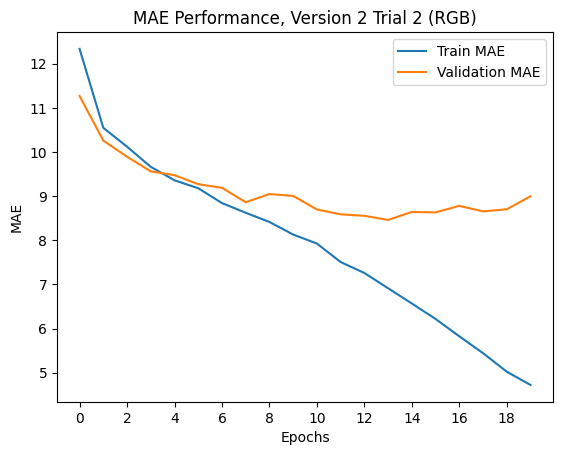

In [54]:
mae_1 = history.history['mean_absolute_error']
val_mae_1 = history.history['val_mean_absolute_error']

plt.plot(mae_1, label='Train MAE')
plt.plot(val_mae_1, label='Validation MAE')
plt.xticks(np.arange(0, 20, 2))
plt.title('MAE Performance, Version 2 Trial 2 (RGB)')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()
plt.show()


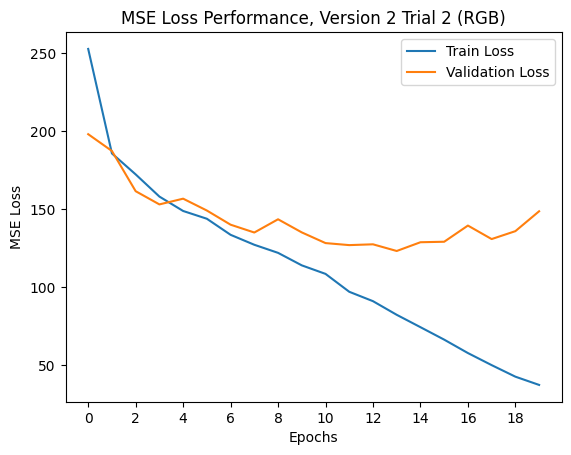

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(np.arange(0, 20, 2))
plt.title('MSE Loss Performance, Version 2 Trial 2 (RGB)')
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()